Welcome to the next part of the demo where we get into the segmentation model itself, running it all in pytorch. However, before we get into the model, we need to make data assecible to a pytorch based model - in other words we need to make the images into tensors!. 

Aslo we need to get ourself a more robust dataset, so we augment the data by introducing guassian blur and roating each imagery either vertically or horiztontally.

Finally everything gets stored in a dataloader, one for each dataset (train, validation, and test). 

However, before we generates the dataloaders, lets load the full dataset from the previous demo 

In [28]:
# load the packages needed
import torch
import tifffile as tiff
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import GaussianBlur
import os, glob, functools, json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopandas as gpd


# load the full data from the previous demo - get it from zendo if you have not made it yourself

def get_train_test_lists(imdir, lbldir,mask_dir):
  imgs = glob.glob(os.path.join(imdir,"*.tiff"))
  #print(imgs[0:1])
  dset_list = []
  for img in imgs:
    filename_split = os.path.splitext(img) 
    filename_zero, fileext = filename_split 
    basename = os.path.basename(filename_zero) 
    dset_list.append(basename)

  x_filenames = []
  y_filenames = []
  mask_filenames=[]
  for img_id in dset_list:
    x_filenames.append(os.path.join(imdir, "{}.tiff".format(img_id)))
    y_filenames.append(os.path.join(lbldir, "{}.tiff".format(img_id)))
    mask_filenames.append(os.path.join(mask_dir, "{}.tiff".format(img_id)))

  print("number of images: ", len(dset_list))
  return dset_list, x_filenames, y_filenames, mask_filenames

# set your own directory
label_dir="/media/mabso/Data/downloads/sen2_placeholder/rasters2/tiled/labels"
img_dir="/media/mabso/Data/downloads/sen2_placeholder/rasters2/tiled/stacks_brightened"
mask_dir="/media/mabso/Data/downloads/sen2_placeholder/rasters2/tiled/masks"

root_dir="/media/mabso/Data/downloads/sen2_placeholder" # set to the dirct where the three folders are stored 

train_list, x_train_filenames, y_train_filenames, mask_train_filenames = get_train_test_lists(img_dir, label_dir,mask_dir)

# get rid of backgrounds

skip = False

if not skip:
  background_list_train = []
  for i in train_list: 
      # read in each labeled images
      # print(os.path.join(label_dir,"{}.png".format(i))) 
      img = np.array(Image.open(os.path.join(label_dir,"{}.tiff".format(i))))  
      # check if no values in image are greater than zero (background value)
      if img.max()==0:
          background_list_train.append(i)

  print("Number of background images: ", len(background_list_train))

  with open(os.path.join(root_dir,'background_list_train.txt'), 'w') as f:
    for item in background_list_train:
        f.write("%s\n" % item)

else:
  background_list_train = [line.strip() for line in open("background_list_train.txt", 'r')]
  print("Number of background images: ", len(background_list_train))


background_removal = len(background_list_train) * 0.9
train_list_clean = [y for y in train_list if y not in background_list_train[0:int(background_removal)]]

x_train_filenames = []
y_train_filenames = []
mask_train_filenames = []

for i, img_id in zip(range(len(train_list_clean)), train_list_clean):
  pass 
  x_train_filenames.append(os.path.join(img_dir, "{}.tiff".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}.tiff".format(img_id)))
  mask_train_filenames.append(os.path.join(mask_dir, "{}.tiff".format(img_id)))
  #print(i)
print("Number of background tiles: ", background_removal)
print("Remaining number of tiles after 90% background removal: ", len(train_list_clean))
#%% split into test, val and train

x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames,mask_train_filenames, mask_val_filenames = train_test_split(x_train_filenames, y_train_filenames,mask_train_filenames, test_size=0.3, random_state=42)
x_val_filenames, x_test_filenames, y_val_filenames, y_test_filenames,mask_val_filenames, mask_test_filenames = train_test_split(x_val_filenames, y_val_filenames,mask_val_filenames, test_size=0.33, random_state=42)

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))
print("Number of test examples: {}".format(num_test_examples))



number of images:  7865
Number of background images:  65
Number of background tiles:  58.5
Remaining number of tiles after 90% background removal:  7807
Number of training examples: 5464
Number of validation examples: 1569
Number of test examples: 774


In [29]:
# set the input of images and the batch size

# image shape
img_shape = (224, 224,11)
# set batch size 
batch_size = 4


# function for converting images to tensors
def _process_pathnames(fname, label_path,mask_path):
    # Read and transform the statelite image
    with open(fname, 'rb') as f:
       img = tiff.imread(f)
       img = transforms.ToTensor()(img)

    # Read and transform the mask image
    with open(label_path, 'rb') as f:
        label_img = Image.open(f)
        label_img=np.uint8(label_img)
        label_img = torch.tensor(label_img) 
        
     # Read and transform the label image
    with open(mask_path, 'rb') as f:
         #mask_img = Image.open(f)
         mask_img = tiff.imread(f)
         mask_img=transforms.ToTensor()(mask_img)
        
    return img, label_img,mask_img

# horizontal flip function
def flip_img_h(horizontal_flip, tr_img, label_img,mask_img):
    if horizontal_flip:
        flip_prob = torch.rand(1).item()
        if flip_prob < 0.5:
            tr_img = transforms.functional.hflip(tr_img)
            label_img = transforms.functional.hflip(label_img)
            mask_img = transforms.functional.hflip(mask_img)
    return tr_img, label_img,mask_img

# vertical flip function
def flip_img_v(vertical_flip, tr_img, label_img ,mask_img):
    if vertical_flip:
        flip_prob = torch.rand(1).item()
        if flip_prob < 0.5:
            tr_img = transforms.functional.vflip(tr_img)
            label_img = transforms.functional.vflip(label_img)
            mask_img = transforms.functional.vflip(mask_img)
    return tr_img, label_img,mask_img

# augmentation function
def _augment(img,
             label_img,
             mask_img,
             resize=None,  # Resize the image to some size e.g. [256, 256] - optional
             scale=None,  # Scale image e.g. 1 / 255. # optinal, should be in the preprocessing part
             horizontal_flip=False, # turn on/off in functional argument
             vertical_flip=False,  # turn on/off in functional argument
             blur_prob=0.5,  # Probability of applying blur
             blur_radius=(5,5)): 
    if resize is not None:
        # Resize the image using F.interpolate
        img = F.interpolate(img.unsqueeze(0), size=resize, mode='bilinear', align_corners=False).squeeze(0)
        # Resize the label image using transforms.functional.resize
        label_img = label_img.unsqueeze(0)  # Add batch dimension
        label_img = transforms.functional.resize(label_img, size=resize)
        label_img = label_img.squeeze(0)  # Remove batch dimension
        
        mask_img = F.interpolate(mask_img.unsqueeze(0), size=resize, mode='bilinear', align_corners=False).squeeze(0)

    img, label_img, mask_img = flip_img_h(horizontal_flip, img, label_img,mask_img)
    img, label_img, mask_img = flip_img_v(vertical_flip, img, label_img,mask_img)

    img = img.float()
    if scale is not None:
        img = img.float() * scale
    # turn off for test imgs
    # Apply Gaussian blur with a certain probability
    if np.random.rand() < blur_prob:
        img = GaussianBlur(kernel_size=blur_radius)(img)

    return img, label_img, mask_img


# convert the tensors to a pytorch dataset
class CustomDataset(Dataset):
    def __init__(self, filenames, labels, masks, preproc_fn=None):
        self.filenames = filenames
        self.labels = labels
        self.masks = masks
        self.preproc_fn = preproc_fn

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        label_path = self.labels[idx]
        mask_path = self.masks[idx]

        # Process pathnames and apply augmentation if preproc_fn is provided
        img, label_img, mask_img = _process_pathnames(fname, label_path,mask_path)
        if self.preproc_fn is not None:
            img, label_img, mask_img = self.preproc_fn(img, label_img, mask_img)

        return img, label_img, mask_img

# create dataloaders with aguments
def get_baseline_dataset(filenames, 
                         labels,
                         masks,
                         preproc_fn=_augment,
                         threads=0,
                         batch_size=batch_size,
                         shuffle=True):
    
    dataset = CustomDataset(filenames, labels,masks, preproc_fn=preproc_fn)

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=threads, pin_memory=False, drop_last=True)

    return data_loader




# generate the augmentation functions to be used in the loaders
def get_baseline_dataset(filenames, 
                         labels,
                         masks,
                         preproc_fn=_augment,
                         threads=0,
                         batch_size=batch_size,
                         shuffle=True):
   # num_x = len(filenames)
    dataset = CustomDataset(filenames, labels,masks, preproc_fn=preproc_fn)

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=threads, pin_memory=False, drop_last=True)

    return data_loader

# dataset configuration for training (scaling optinal - should have been done in the preprocessing part)
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    #'scale': 1 / 255.,
    'horizontal_flip': True,
    'vertical_flip': True,
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

# dataset configuration for validation
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
   # 'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

# dataset configuration for testing
test_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    #'scale': 1 / 255.,
}
test_preprocessing_fn = functools.partial(_augment, **test_cfg)


# now generate the training, validation and test loaders 

train_ds =get_baseline_dataset(x_train_filenames, 
                         y_train_filenames,
                         mask_train_filenames,
                         preproc_fn=tr_preprocessing_fn,
                         threads=5,
                         batch_size=batch_size,
                         shuffle=True)

val_ds =get_baseline_dataset(x_val_filenames, 
                         y_val_filenames,
                         mask_val_filenames,
                         preproc_fn=tr_preprocessing_fn,
                         threads=0,
                         batch_size=batch_size,
                         shuffle=False)


test_ds =get_baseline_dataset(x_test_filenames, 
                         y_test_filenames,
                         mask_test_filenames,
                         preproc_fn=tr_preprocessing_fn,
                         threads=0,
                         batch_size=batch_size,
                         shuffle=False)





Lets test what comes out of the dataloaders to see if it makes sense.

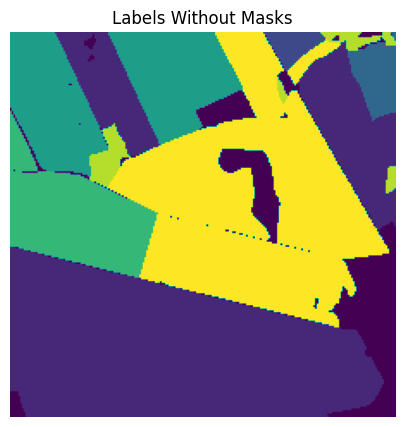

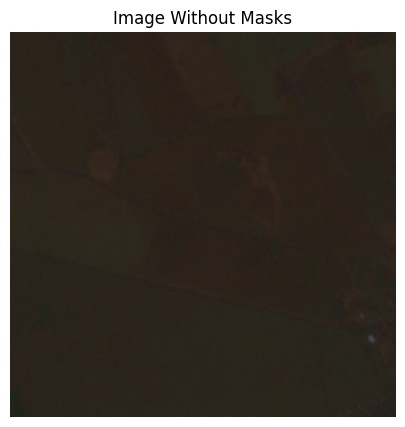

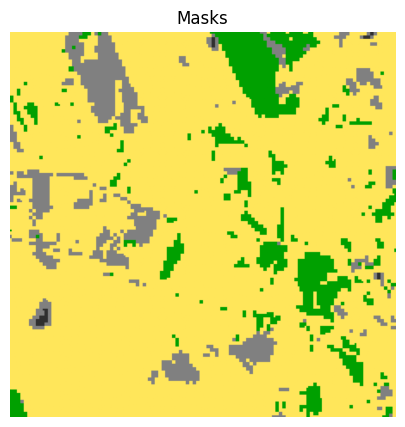

In [30]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

temp_batch = next(iter(train_ds))


sample_image, sample_label, sample_mask = temp_batch[0], temp_batch[1],temp_batch[2]

img_idx=0

# Plot the label before applying masks
plt.figure(figsize=(10, 5))
plt.title("Labels Without Masks")
plt.imshow(sample_label[img_idx, :, :].squeeze().numpy().transpose(0, 1).astype(np.uint8))
plt.axis("off")
plt.show()

# Plot the image before applying masks
plt.figure(figsize=(10, 5))
plt.title("Image Without Masks")
plt.imshow(sample_image[img_idx, :, :].numpy().transpose(1, 2, 0)[:, :, [0, 1, 2]])
plt.axis("off")
plt.show()

# Plot the masks
plt.figure(figsize=(10, 5))
plt.title("Masks")
plt.imshow(sample_mask[img_idx, :, :].numpy().transpose(1, 2, 0)[:, :, [0, 1, 2]])
plt.axis("off")
plt.show()



the next step is to be able to utalize the masks of the screen classifcation landscape such that unwated pixels, eg water, shadows, clouds and no might be removed from both images and labels within each batch. To do so we introduce the following function

In [31]:
def isolate_masks(scl,cover):
    
    scl=(scl*255).to(torch.long)

       
    # (47,47,47) = shadows - unique 47 all channels i=1
    # (100,50,0) = cloud shadows - unique 50 green channel (100,50,0), i=2
    # (0,160,0) = vegitation - unique 160 green channel (0,160,0), i=7
    # (100,50,0)= cloud shadows -  unique 50 green channel (100,50,0), i= 3
    # (255,230,90)= not vegitation - unique 90 blue channel (255,230,90) , i=4
    # (0,0,255) = water - none unique value, i=10
    # (128,128,128)=other - 128 unique all channels, i= 5
    # (192,192,192)= medium cloud -192 unique all channels, i=8
    # (255,255,255)= high cloud - 255 not unique all channels, i=10
    # (100,200,255)= thin cirrus - 200 unique green channel, i= (not in first image)
    # (255,150,255)=ice/snow - 150 unique green channel, i = 6
    
    # something wrong with tiff to png conversion:
    # following correction included:
    # 130 = 131
    # 160 = 161
    # 128 = 129
    # 192 = 193
    # 
    
    if (cover=="blank"):
        # no data
        idx=np.where((scl[0]==0) & (scl[1]==0) & (scl[2]==0) )
    
    elif (cover=="dead"):
        # dead pixels 
        idx=np.where((scl[0]==255) & (scl[1]==0) & (scl[2]==0) )
    
    elif (cover=="dark"):
        # dark area/shadows
        idx=np.where((scl[0]==47) & (scl[1]==47) & (scl[2]==47) )
    
    elif (cover=="cloud_shadow"):
        # vegitation
        idx=np.where((scl[0]==100) & (scl[1]==50) & (scl[2]==0) )
    
    elif (cover=="vegi"):
        # cloud shadows
        idx=np.where((scl[0]==0) & (scl[1]==160) & (scl[2]==0) )
    
    elif (cover=="not_vegi"):
        # not vegitation
        idx=np.where((scl[0]==255) & (scl[1]==230) & (scl[2]==90) )
    
    elif (cover=="water"):
        # water
        idx=np.where((scl[0]==0) & (scl[1]==0) & (scl[2]==255) )
    
    elif (cover=="no_class"):
        # not classifed
        idx=np.where((scl[0]==129) & (scl[1]==129) & (scl[2]==129) )
    
    elif (cover=="medium_cloud"):
        # medium cloud
        idx=np.where((scl[0]==193) & (scl[1]==193) & (scl[2]==193) )
    
    elif (cover=="thick_cloud"):
    # thick cloud
        idx=np.where((scl[0]==255) & (scl[1]==255) & (scl[2]==255) )
    
    elif (cover=="cirrus"):
        # thin cirrus 
        idx=np.where((scl[0]==100) & (scl[1]==200) & (scl[2]==255) )
    
    elif (cover=="snow"):
        # ice/snow
        idx=np.where((scl[0]==255) & (scl[1]==150) & (scl[2]==255) )
    
    mask0 = np.zeros(scl.shape[1:], dtype=bool)
    mask0[idx] = True
    
    return mask0
 
def isolate_masks_batch(images, cover):
    masks = []
    
    for i in range(images.shape[0]):
        mask0 = isolate_masks(images[i], cover)
        masks.append(mask0)
        
        
    return np.stack(masks)
    


Lets see what happens when the mask function is being applied to images from a batch

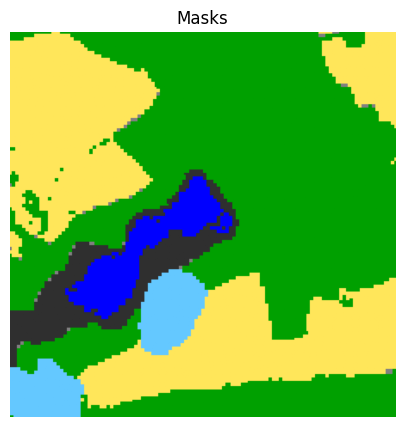

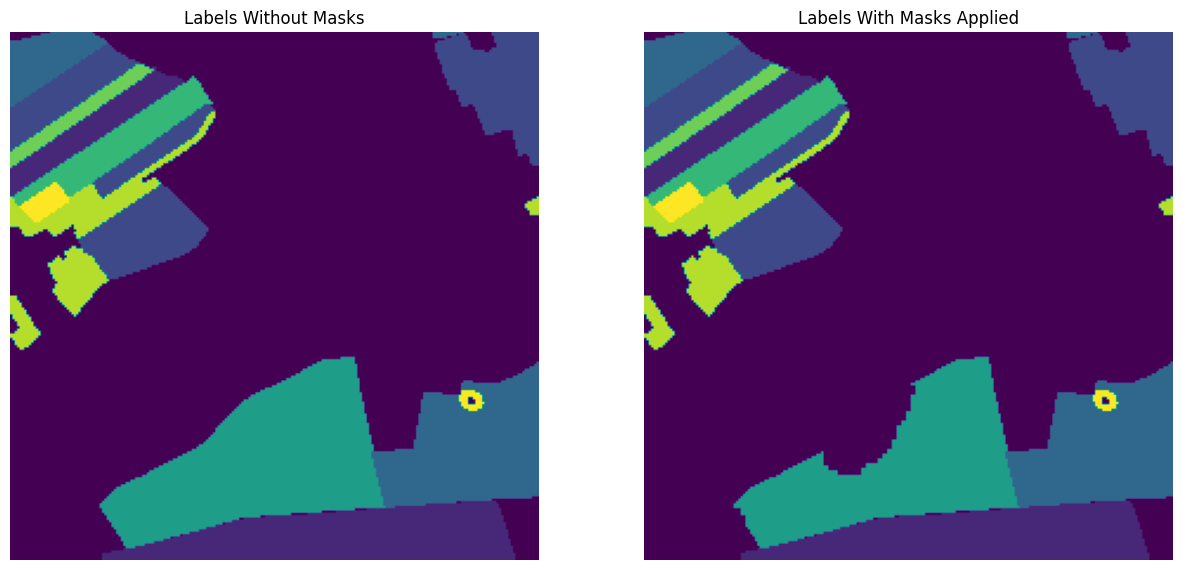

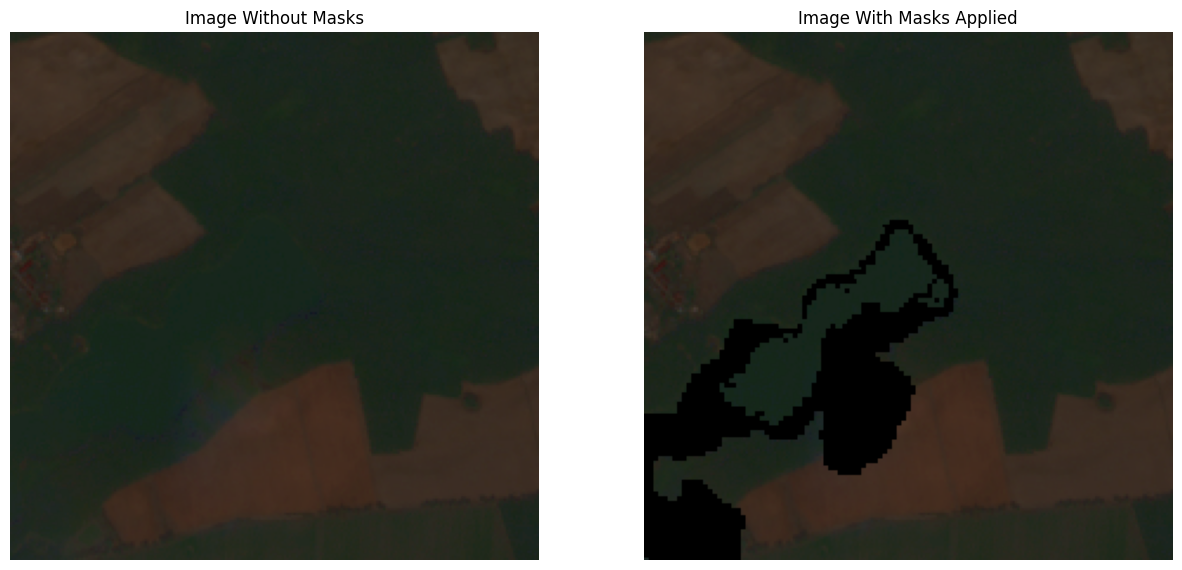

In [32]:
# load a random batch of images, labels and masks
temp_batch = next(iter(train_ds))

sample_image, sample_label, sample_mask = temp_batch[0], temp_batch[1],temp_batch[2]


# pick a random image, label and mask from the batch and apply the mask function to view the effects

img_idx=0


# Plot the masks
plt.figure(figsize=(10, 5))
plt.title("Masks")
plt.imshow(sample_mask[img_idx, :, :].numpy().transpose(1, 2, 0)[:, :, [0, 1, 2]])
plt.axis("off")
plt.show()


# generate the masks
multi_mask_dark=isolate_masks_batch(sample_mask, "dark")
multi_mask_medium_clouds=isolate_masks_batch(sample_mask, "medium_cloud")
multi_mask_thick_clouds=isolate_masks_batch(sample_mask, "thick_cloud")
multi_mask_cloud_shadow=isolate_masks_batch(sample_mask, "cloud_shadow")
multi_mask_cirrus=isolate_masks_batch(sample_mask, "cirrus")
multi_mask_snow=isolate_masks_batch(sample_mask, "snow")

# apply the masks
mask0 = torch.tensor((np.tile(~multi_mask_medium_clouds[:,:, :, np.newaxis], (1, 1, 1, 11))).transpose(0, 3, 1, 2))
mask1 = torch.tensor((np.tile(~multi_mask_thick_clouds[:,:, :, np.newaxis], (1, 1, 1, 11))).transpose(0, 3, 1, 2))
mask2 = torch.tensor((np.tile(~multi_mask_cloud_shadow[:,:, :, np.newaxis], (1, 1, 1, 11))).transpose(0, 3, 1, 2))
mask3 = torch.tensor((np.tile(~multi_mask_cirrus[:,:, :, np.newaxis], (1, 1, 1, 11))).transpose(0, 3, 1, 2))
mask4 = torch.tensor((np.tile(~multi_mask_snow[:,:, :, np.newaxis], (1, 1, 1, 11))).transpose(0, 3, 1, 2))
mask5 = torch.tensor((np.tile(~multi_mask_dark[:,:, :, np.newaxis], (1, 1, 1, 11))).transpose(0, 3, 1, 2))

# apply the masks to each label and image
sample_image1=sample_image*mask0*mask1*mask2*mask3*mask4*mask5                 
sample_label1=sample_label*mask0[:,-1]*mask1[:,-1]*mask2[:,-1]*mask3[:,-1]*mask4[:,-1]*mask5[:,-1]  


# Set up side-by-side plots for labels
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].set_title("Labels Without Masks")
axes[0].imshow(sample_label[img_idx, :, :].squeeze().numpy().transpose(0, 1).astype(np.uint8))
axes[0].axis("off")

axes[1].set_title("Labels With Masks Applied")
axes[1].imshow(sample_label1[img_idx, :, :].squeeze().numpy().transpose(0, 1).astype(np.uint8))
axes[1].axis("off")

plt.show()

# Set up side-by-side plots for images
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].set_title("Image Without Masks")
axes[0].imshow(sample_image[img_idx, :, :].numpy().transpose(1, 2, 0)[:, :, [0, 1, 2]])
axes[0].axis("off")

axes[1].set_title("Image With Masks Applied")
axes[1].imshow(sample_image1[img_idx, :, :].numpy().transpose(1, 2, 0)[:, :, [0, 1, 2]])
axes[1].axis("off")

plt.show()

We are now ready to procced as all data is now in the correct tensor format, have the possiblity of augmentation and masks can be applied. 

The first step is to figure out what type of model we should use. In a task where we wish to segment imagery, there is a lot to choose from. A pouplar choice is that of the unet familiy which are all implemtented within the pytorch segmentation_models_pytorch package. Here we choose the Unet++ model. 

Next step is to define the loss function, the standard choice would be to apply the cross entropy loss in combination with a softmax output layer such that proabilitics predicts of each label is generated. In this case we do something different, as one class the root crop is underrepresented, we make up for it by introducing the focal loss. This is almost similar to the cross entropy but has an addtional two parameters of class weights ($\alpha$) and focus ($\gamma$).


$$
loss= -\sum \alpha_i (1-p_i)^{\gamma} \log(p_i)
$$

Here the it is clear that if $\gamma=0$ then the loss would reduced itself to the weighted cross entropy and if the weights ($\alpha$) are equal, the loss would reduce to the usual cross entropy. The main idea is that $\alpha$ gives lower weights the majority class, while $\gamma=0$ lower the influence of the easy to classify examples (the higher the value the less inlfuence easy cases will have on the over all loss).

For optimization we utalize the standard first order ADAM optimizer where we include a dropout chance at 0.25 for addtional regularization.

Following training we store the mean pixel accuracy, loss, and IOU (boundery box overlapping correctness) for both traning and validation sets 

In [35]:
# lets define the weights (alpha) of the focal loss

# load labels from the geojson file provided
train_df = gpd.read_file('/media/mabso/Data/downloads/sen2_placeholder/training_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/labels.geojson')
inv_freq = np.array(1/(train_df.crop_id.value_counts()/len(train_df)))
inv_freq = [0.,*inv_freq]
class_weights = {0 : inv_freq[0], 1: inv_freq[1], 2: inv_freq[2], 3: inv_freq[3], 
                4: inv_freq[4], 5: inv_freq[5], 6: inv_freq[6],
                7: inv_freq[7], 8: inv_freq[8], 9: inv_freq[9]}


def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


class_weights_list = list(class_weights.values())
scaled_class_weights = NormalizeData(class_weights_list)
scaled_class_weights_list = torch.tensor(scaled_class_weights.tolist()) 


# implementing the focal loss
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='mean')
        pt = torch.exp(-ce_loss)
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * ce_loss).mean()
        return loss


# load the unet++ model
import segmentation_models_pytorch as smp

model=smp.UnetPlusPlus(encoder_name="efficientnet-b0",encoder_weights="imagenet",
               classes=10,activation="softmax2d",in_channels=11)

aux_params=dict(
    dropout=0.25,               # dropout ratio, default is None
    classes=10,                 # define number of output labels, we have 9 crop types and 1 background class
)

# choose optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# select gpu if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set up the focal loss
criterion = FocalLoss(gamma=2.0,alpha=scaled_class_weights_list.to(device))#.to(device)

# move model to gpu
model=model.to(device)


The next step is now to define the traning and validation loop, storing loss, IOU and mean pixel accuracy

In [ ]:
from tqdm import tqdm
from sklearn.metrics import jaccard_score


def train(model, train_dataloader, optimizer):
    model.train()
    epoch_loss = 0.0
    train_iou =0.0
    train_samples =0.0
    running_pixel_acc = 0.0
    running_mean_acc = 0.0
    
    with tqdm(enumerate(train_dataloader), total=len(train_dataloader),position=0, leave=True) as iterator:
        for idx, batch in iterator:
            inputs=batch[0].type(torch.float32).to(device)
        
            labels = batch[1].to(torch.long).to(device)
             
            scl = batch[2].to("cpu")
           
            
            multi_mask_medium_clouds=isolate_masks_batch(scl, "medium_cloud")
            multi_mask_thick_clouds=isolate_masks_batch(scl, "thick_cloud")
            multi_mask_cloud_shadow=isolate_masks_batch(scl, "cloud_shadow")
            multi_mask_cirrus=isolate_masks_batch(scl, "cirrus")
            multi_mask_snow=isolate_masks_batch(scl, "snow")
            
            mask0 = torch.tensor((np.tile(~multi_mask_medium_clouds[:,:, :, np.newaxis], (1, 1, 1, 11))).transpose(0, 3, 1, 2)).to(device)
            mask1 = torch.tensor((np.tile(~multi_mask_thick_clouds[:,:, :, np.newaxis], (1, 1, 1, 11))).transpose(0, 3, 1, 2)).to(device)
            mask2 = torch.tensor((np.tile(~multi_mask_cloud_shadow[:,:, :, np.newaxis], (1, 1, 1, 11))).transpose(0, 3, 1, 2)).to(device)
            mask3 = torch.tensor((np.tile(~multi_mask_cirrus[:,:, :, np.newaxis], (1, 1, 1, 11))).transpose(0, 3, 1, 2)).to(device)
            mask4 = torch.tensor((np.tile(~multi_mask_snow[:,:, :, np.newaxis], (1, 1, 1, 11))).transpose(0, 3, 1, 2)).to(device)
            
            inputs=inputs*mask0*mask1*mask2*mask3*mask4                
          
            labels=labels*mask0[:,-1]*mask1[:,-1]*mask2[:,-1]*mask3[:,-1]*mask4[:,-1]  
            
            optimizer.zero_grad()
           
            outputs,_ = model(inputs)#['out']
            
            loss = criterion(outputs,labels)
            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            iterator.set_description(f"train loss={loss:.2f}")
            
            # get iou as well
            predicted_labels = torch.argmax(outputs, dim=1)
            iou = jaccard_score(labels.cpu().flatten(), predicted_labels.cpu().flatten(), average='micro')
            batch_size = inputs.size(0)
            train_iou += iou * batch_size
            train_samples += batch_size
            
            pixel_acc = (predicted_labels == labels.squeeze()).sum().item() / predicted_labels.numel()
            mean_acc = torch.count_nonzero(labels.squeeze() == predicted_labels) / torch.numel(labels.squeeze())
            
            
            running_pixel_acc += pixel_acc
            running_mean_acc += mean_acc
            
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    avg_train_iou = train_iou / train_samples
    epoch_pixel_acc = running_pixel_acc / len(train_dataloader)
    epoch_mean_acc = running_mean_acc / len(train_dataloader)
    
    
    return torch.tensor([avg_epoch_loss]),torch.tensor([avg_train_iou]),torch.tensor([epoch_pixel_acc]),torch.tensor([epoch_mean_acc])

def validate(model, val_dataloader):
    model.eval()
    epoch_loss = 0.0
    val_iou = 0.0
    val_samples = 0
    running_pixel_acc=0.0
    running_mean_acc=0.0
    with torch.no_grad():
        with tqdm(enumerate(val_dataloader), total=len(val_dataloader), position=0, leave=True) as iterator:
           for idx, batch in iterator:
                inputs=batch[0].type(torch.float32).to(device)
              
                labels = batch[1].to(torch.long).to(device)
                
                scl = batch[2].to("cpu")
                
                multi_mask_medium_clouds=isolate_masks_batch(scl, "medium_cloud")
                multi_mask_thick_clouds=isolate_masks_batch(scl, "thick_cloud")
                multi_mask_cloud_shadow=isolate_masks_batch(scl, "cloud_shadow")
                multi_mask_cirrus=isolate_masks_batch(scl, "cirrus")
                multi_mask_snow=isolate_masks_batch(scl, "snow")
                
                
                mask0 = torch.tensor((np.tile(~multi_mask_medium_clouds[:,:, :, np.newaxis], (1, 1, 1, 11))).transpose(0, 3, 1, 2)).to(device)
                mask1 = torch.tensor((np.tile(~multi_mask_thick_clouds[:,:, :, np.newaxis], (1, 1, 1, 11))).transpose(0, 3, 1, 2)).to(device)
                mask2 = torch.tensor((np.tile(~multi_mask_cloud_shadow[:,:, :, np.newaxis], (1, 1, 1, 11))).transpose(0, 3, 1, 2)).to(device)
                mask3 = torch.tensor((np.tile(~multi_mask_cirrus[:,:, :, np.newaxis], (1, 1, 1, 11))).transpose(0, 3, 1, 2)).to(device)
                mask4 = torch.tensor((np.tile(~multi_mask_snow[:,:, :, np.newaxis], (1, 1, 1, 11))).transpose(0, 3, 1, 2)).to(device)
                
                inputs=inputs*mask0*mask1*mask2*mask3*mask4                

                labels=labels*mask0[:,-1]*mask1[:,-1]*mask2[:,-1]*mask3[:,-1]*mask4[:,-1] 
            
    
                outputs,_ = model(inputs)#['out'] # incase resnet use output,_
                
                loss = criterion(outputs, labels)
              
                
                epoch_loss += loss.item()
    
                predicted_labels = torch.argmax(outputs, dim=1)
                iou = jaccard_score(labels.cpu().flatten(), predicted_labels.cpu().flatten(), average='micro')
                batch_size = inputs.size(0)
                val_iou += iou * batch_size
                val_samples += batch_size
              
                pixel_acc = (predicted_labels == labels.squeeze()).sum().item() / predicted_labels.numel()
            
                mean_acc = torch.count_nonzero(labels.squeeze() == predicted_labels) / torch.numel(labels.squeeze())
                
                running_pixel_acc += pixel_acc
                running_mean_acc += mean_acc
    
                iterator.set_description(f"valid loss={loss:.2f}")

        avg_val_iou = val_iou / val_samples
        avg_epoch_loss = epoch_loss / len(val_dataloader)
        epoch_pixel_acc = running_pixel_acc / len(val_dataloader)
        epoch_mean_acc = running_mean_acc / len(val_dataloader)
    
    return torch.tensor([avg_epoch_loss]),torch.tensor([avg_val_iou]),torch.tensor([epoch_pixel_acc]),torch.tensor([epoch_mean_acc])

# run the traning 

# Initialize variables
num_epochs = 200
train_loss_l = []
train_iou_l = []
train_pixel_l = []
train_acc_l = []

val_loss_l = []
val_iou_l = []
val_pixel_l = []
val_acc_l = []

best_val_loss = float('inf')  # Initialize with a large value
model_path = os.path.join(os.getcwd(), "model_demo_version1.pth")

# Training loop
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxnUw()
    for epoch in range(num_epochs):
        train_loss, train_iou, train_pixel, train_acc = train(model, train_ds, optimizer)
        val_loss, val_iou, val_pixel, val_acc = validate(model, val_ds)
        
        # Record training metrics
        train_loss_l.append(train_loss)
        train_iou_l.append(train_iou)
        train_pixel_l.append(train_pixel)
        train_acc_l.append(train_acc)
        
        # Record validation metrics
        val_loss_l.append(val_loss)
        val_iou_l.append(val_iou)
        val_pixel_l.append(val_pixel)
        val_acc_l.append(val_acc)
        
        # Print metrics
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss_l[epoch][0]:.4f} - "
              f"Train IoU: {train_iou_l[epoch][0]:.4f} - Train Acc: {train_acc_l[epoch][0]:.4f} - "
              f"Train Pix_Acc: {train_pixel_l[epoch][0]:.4f} - Val Loss: {val_loss_l[epoch][0]:.4f} - "
              f"Val IoU: {val_iou_l[epoch][0]:.4f} - Val Acc: {val_acc_l[epoch][0]:.4f} - "
              f"Val Pix_Acc: {val_pixel_l[epoch][0]:.4f}")
        
        # Save the model if validation loss improves
        if val_loss[0] < best_val_loss:
            best_val_loss = val_loss[0]
            print(f"Validation loss improved to {best_val_loss:.4f}, saving model.")
            torch.save({
                'epoch': epoch,
                'train_loss_l': train_loss_l,
                'val_loss_l': val_loss_l,
                'train_acc_l': train_acc_l,
                'val_acc_l': val_acc_l,
                'train_iou_l': train_iou_l,
                'val_iou_l': val_iou_l,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, model_path)


